####    Compare gradient results from the 012326 distance vs structural conn and 011426 distance vs functional conn. Gradients were thresholded based on tract average length (from NKI dataset)

In [97]:
import pickle 
import re
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

#save gradient outputs
TARGET_DISTANCE = 'short' # short or long
loadpath_structuralconn = f'../012325_distance_vs_structuralconn/gradients_output/{TARGET_DISTANCE}'
loadpath_functionalconn = f'../011426_distance_vs_functionalconn/gradients_output/{TARGET_DISTANCE}'

#structuralconn_data = pickle.load(open(os.path.join(loadpath_structuralconn, 'lh_data_all_and_tract_distance_aligned_range.pkl'), 'rb'))#use aligned data (aligned to hcp direction only*)
structuralconn_data = pickle.load(open(os.path.join(loadpath_structuralconn, 'lh_data_all_and_tract_distance_range.pkl'), 'rb'))
functionalconn_data = pickle.load(open(os.path.join(loadpath_functionalconn, 'lh_data_all_and_tract_distance_range.pkl'), 'rb'))
tract_length_range = structuralconn_data['TRACT_DISTANCE_RANGE']

####    Perform spatial correlation

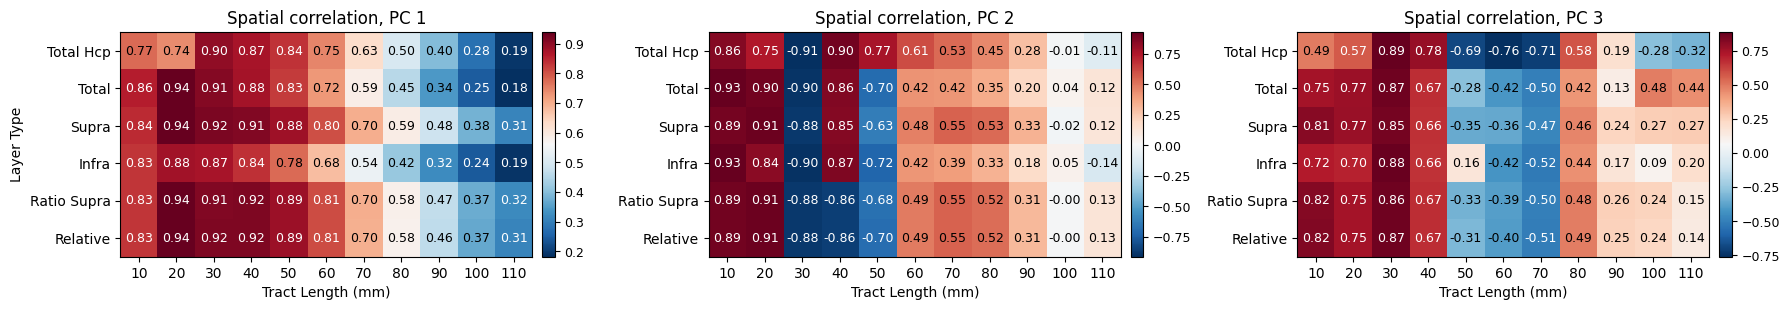

In [98]:


PC2PLOT = 3 # Number of principal components to plot

# Prepare to collect correlation matrices for each PC
corr_mats = []

if any(re.search(r'aligned', k) for k in structuralconn_data.keys()):
    # data we loaded are aligned
    key_name = 'lh_aligned_all'
else:
    key_name = 'lh_data_all'

for PC_INDEX in range(PC2PLOT):
    corr_mat_all = []
    for tractlen in np.arange(len(tract_length_range)):
        corr_mat = []
        functional_data = functionalconn_data['lh_data_all']['hcp'][tractlen][:, PC_INDEX]
        for layer_type in structuralconn_data[key_name].keys():
            structural_data = structuralconn_data[key_name][layer_type][tractlen][:, PC_INDEX]
            corr_value = np.corrcoef(functional_data, structural_data)[0, 1]
            corr_mat.append(corr_value)
        corr_mat_all.append(corr_mat)
    corr_mats.append(np.array(corr_mat_all))

# Plot all PCs in one row (1 x PC2PLOT)
fig, axs = plt.subplots(1, PC2PLOT, figsize=(6 * PC2PLOT, 6), squeeze=False)
cmap = plt.get_cmap('RdBu_r')

from mpl_toolkits.axes_grid1 import make_axes_locatable

for PC_INDEX in range(PC2PLOT):
    corr_mat_all = corr_mats[PC_INDEX]
    ax = axs[0, PC_INDEX]
    im = ax.imshow(corr_mat_all.T, cmap=cmap)

    # Annotate each cell with the correlation value
    norm = mcolors.Normalize(vmin=np.min(corr_mat_all), vmax=np.max(corr_mat_all))
    threshold = 0.5  # threshold for background brightness to switch to white text

    for i in range(corr_mat_all.shape[0]):  # tractlen (x-axis)
        for j in range(corr_mat_all.shape[1]):  # layer_type (y-axis)
            value = corr_mat_all[i, j]
            rgba = cmap(norm(value))
            # Compute perceived brightness of the background
            r, g, b, _ = rgba
            brightness = 0.299 * r + 0.587 * g + 0.114 * b
            text_color = "white" if brightness < threshold else "black"
            ax.text(i, j, f"{value:.2f}", ha="center", va="center", color=text_color, fontsize=9)

    ax.set_yticks(np.arange(len(structuralconn_data[key_name].keys())))
    ax.set_yticklabels([k.replace('_', ' ').title() for k in structuralconn_data[key_name].keys()])
    ax.set_xticks(np.arange(len(tract_length_range)))
    ax.set_xticklabels(tract_length_range)
    ax.set_xlabel('Tract Length (mm)')
    if PC_INDEX == 0:
        ax.set_ylabel('Layer Type')
    else:
        ax.set_ylabel("")
    ax.set_title('Spatial correlation, PC %d' % (PC_INDEX + 1))

    # Use make_axes_locatable to fit and shrink the colorbar to the height of the image only
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)  # size is relative: '3%' is small
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


In [99]:
print(functional_data.shape)

(32492,)
